### 1. Import SpaceFlow and squidpy package

In [1]:
import squidpy as sq
from SpaceFlow import SpaceFlow

/Users/emmanueldollinger/.local/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2. Load the ST data from squidpy package

In [2]:
adata = sq.datasets.seqfish()

### 3. Create SpaceFlow Object

We create a SpaceFlow object using the count matrix of gene expression and the corresponding spatial locations of cells (or spots):

In [3]:
sf = SpaceFlow.SpaceFlow(expr_data=adata.X, 
                         spatial_locs=adata.obsm['spatial'])

Parameters:
- `expr_data`: the count matrix of gene expression, 2D numpy array of size (# of cells, # of genes)
- `spatial_locs`: spatial locations of cells (or spots) match to rows of the count matrix, 1D numpy array of size (n_locations,)

### 4. Preprocessing the ST Data
Next, we preprocess the ST data by run:

In [4]:
sf.preprocessing_data(n_top_genes=3000)

Parameters:
- `n_top_genes`: the number of the top highly variable genes.

The preprocessing includes the normalization and log-transformation of the expression count matrix, the selection of highly variable genes, and the construction of spatial proximity graph using spatial coordinates. (Details see the `preprocessing_data` function in `SpaceFlow/SpaceFlow.py`)


### 5. Train the deep graph network model

We then train a spatially regularized deep graph network model to learn a low-dimensional embedding that reflecting both expression similarity and the spatial proximity of cells in ST data.  


In [5]:
sf.train(spatial_regularization_strength=0.1, 
         z_dim=50, 
         lr=0.001, 
         epochs=1000, 
         max_patience=50, 
         min_stop=100, 
         random_seed=42, 
         gpu=0)

Epoch 2/1000, Loss: 1.6085474491119385
Epoch 12/1000, Loss: 1.263059377670288
Epoch 22/1000, Loss: 1.27500581741333
Epoch 32/1000, Loss: 1.1201385259628296
Epoch 42/1000, Loss: 0.9980056881904602
Epoch 52/1000, Loss: 0.8585752844810486
Epoch 62/1000, Loss: 0.7284411191940308
Epoch 72/1000, Loss: 0.5923753380775452
Epoch 82/1000, Loss: 0.4588884115219116
Epoch 92/1000, Loss: 0.35476043820381165
Epoch 102/1000, Loss: 0.2695678174495697
Epoch 112/1000, Loss: 0.22023378312587738
Epoch 122/1000, Loss: 0.17536373436450958
Epoch 132/1000, Loss: 0.1489028036594391
Epoch 142/1000, Loss: 0.1367858499288559
Epoch 152/1000, Loss: 0.1164274513721466
Epoch 162/1000, Loss: 0.10817990452051163
Epoch 172/1000, Loss: 0.1018778458237648
Epoch 182/1000, Loss: 0.09997484087944031
Epoch 192/1000, Loss: 0.09863860160112381
Epoch 202/1000, Loss: 0.08792280405759811
Epoch 212/1000, Loss: 0.08588029444217682
Epoch 222/1000, Loss: 0.08120979368686676
Epoch 232/1000, Loss: 0.07643358409404755
Epoch 242/1000, Loss

array([[ 2.0610976 , -0.7016203 ,  1.2882041 , ...,  2.1314862 ,
        -0.84702885,  1.3803124 ],
       [ 2.0957289 , -0.64837176,  1.5232906 , ...,  2.0596945 ,
        -0.764296  ,  1.5021138 ],
       [ 1.2101462 , -0.09683014,  0.04976895, ...,  0.04030844,
        -0.18112627,  0.4185493 ],
       ...,
       [-0.26348558, -0.11657362, -0.25933567, ...,  0.3857002 ,
         1.9901385 , -0.03955883],
       [ 3.3369443 , -0.42895913, -0.19364826, ...,  2.1923404 ,
        -0.17906387, -0.14311373],
       [-0.0148525 , -0.07477577,  0.406121  , ...,  1.6098467 ,
        -0.02471215, -0.18611279]], dtype=float32)

Parameters:
- `spatial_regularization_strength`: the strength of spatial regularization, the larger the more of the spatial coherence in the identified spatial domains and spatiotemporal patterns. (default: 0.1)
- `z_dim`: the target size of the learned embedding. (default: 50)
- `lr`: learning rate for optimizing the model. (default: 0.001)
- `epochs`: the max number of the epochs for model training. (default: 1000)
- `max_patience`: the max number of the epoch for waiting the loss decreasing. If loss does not decrease for epochs larger than this threshold, the learning will stop, and the model with the parameters that shows the minimal loss are kept as the best model. (default: 50) 
- `min_stop`: the earliest epoch the learning can stop if no decrease in loss for epochs larger than the `max_patience`. (default: 100) 
- `random_seed`: the random seed set to the random generators of the `random`, `numpy`, `torch` packages. (default: 42)
-  `gpu`: the index of the Nvidia GPU, if no GPU, the model will be trained via CPU, which is slower than the GPU training time. (default: 0) 


### 6. Domain segmentation of the ST data

After the model training, the learned low-dimensional embedding can be accessed through `sf.embedding`.

SpaceFlow will use this learned embedding to identify the spatial domains based on [Leiden](https://www.nature.com/articles/s41598-019-41695-z) algorithm. 


In [6]:
sf.segmentation(domain_label_save_filepath="./domains.tsv", 
                n_neighbors=50, 
                resolution=1.0)

Performing domain segmentation
Segmentation complete, domain labels of cells or spots saved at ./domains.tsv !


Parameters:

- `domain_label_save_filepath`: the file path for saving the identified domain labels. (default: "./domains.tsv")
- `n_neighbors`: the number of the nearest neighbors for each cell for constructing the graph for Leiden using the embedding as input. (default: 50)
- `resolution`: the resolution of the Leiden clustering, the larger the coarser of the domains. (default: 1.0)


### 7. Visualization of the identified spatial domains

We next plot the spatial domains using the identified domain labels and spatial coordinates of cells.

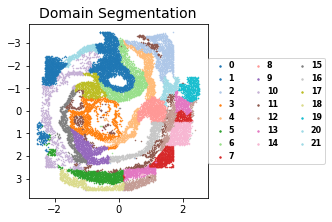

Plotting complete, segmentation figure saved at ./domain_segmentation.pdf !


In [7]:
sf.plot_segmentation(segmentation_figure_save_filepath="./domain_segmentation.pdf", 
                     colormap="tab20", 
                     scatter_sz=1.)

Parameters:
- `segmentation_figure_save_filepath`: the file path for saving the figure of the spatial domain visualization. (default: "./domain_segmentation.pdf")
- `colormap`: the colormap of the different domains, full colormap options see [matplotlib](https://matplotlib.org/3.5.1/tutorials/colors/colormaps.html)
- `scatter_sz`: the marker size in points. (default: 1.0)


We can also visualize the expert annotation for comparison by:

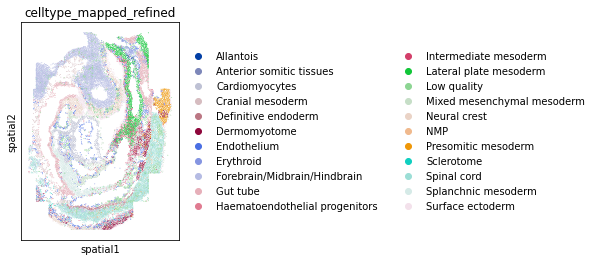

In [3]:
import scanpy as sc
sc.pl.spatial(adata, 
    color="celltype_mapped_refined",
    spot_size=0.03)

### 8. Idenfify the spatiotemporal patterns of the ST data through pseudo-Spatiotemporal Map (pSM)

Next, we apply the diffusion pseudotime (dpt) algorithm to the learned spatially-consistent embedding to generate a pseudo-Spatiotemporal Map (pSM). This pSM represents a spatially-coherent pseudotime ordering of cells that encodes biological relationships between cells, such as developmental trajectories and cancer progression


In [8]:
sf.pseudo_Spatiotemporal_Map(pSM_values_save_filepath="./pSM_values.tsv", 
                             n_neighbors=20, 
                             resolution=1.0, 
                             cell_number_threshold_for_subsampling=5000)

Performing pseudo-Spatiotemporal Map
pseudo-Spatiotemporal Map(pSM) calculation complete, pSM values of cells or spots saved at ./pSM_values.tsv!


Parameters:
- `pSM_values_save_filepath` : the file path for saving the inferred pSM values. 
- `n_neighbors`: the number of the nearest neighbors for each cell for constructing the graph for Leiden using the embedding as input. (default: 20)  
- `resolution`: the resolution of the Leiden clustering, the larger the coarser of the domains. (default: 1.0)
- `cell_number_threshold_for_subsampling`: the threshold for the number of cells to subsampling for identifying the root cell. If the cell number is larger than this threshold, a cell population with `cell_number_threshold_for_subsampling` size will be randomly selected to infer the root cell. (default: 5000)


### 9. Visualization of the identified pseudo-Spatiotemporal Map (pSM)

We next visualize the identified pseudo-Spatiotemporal Map (pSM).


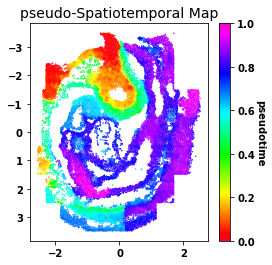

Plotting complete, pseudo-Spatiotemporal Map figure saved at ./pseudo-Spatiotemporal-Map.pdf !


In [9]:
sf.plot_pSM(pSM_figure_save_filepath="./pseudo-Spatiotemporal-Map.pdf", 
            colormap="gist_rainbow", 
            scatter_sz=1.)

Parameters:
- `pSM_figure_save_filepath`: the file path for saving the figure of the pSM visualization. (default: "./pseudo-Spatiotemporal-Map.pdf")
- `colormap`:  the colormap of the pSM, full colormap options see [matplotlib](https://matplotlib.org/3.5.1/tutorials/colors/colormaps.html)
-  `scatter_sz`: the marker size in points. (default: 1.0)   
